In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import astropy.timeseries as ap

In [2]:
def read_and_clean(filename):
    '''
    Function takes input as filename to be cleaned. Rows that have values of nan are deleted. 
    Remaining rows are returned as an ndarray.
    '''
    data = np.genfromtxt(filename)
    data = np.delete(data, np.where(np.isnan(data))[0], axis=0)
    
    return data

<i>Using the convolve function was not an original idea - I would like to thank Stackoverflow for this.</i>

In [3]:
def smooth_data(data, width):
    '''
    This function takes the rolling/moving average of the fluxes - second column of the 'data' array
    This is done by using the numpy.convolve method. 
    '''
    return np.convolve(data[:,1], np.ones(width), 'valid')/width 

<i>The below function is not a very optimal section of the code as the peak gives the wrong time periods and hence the selection needs to be modified such that we only look at frequencies that lie prior to 0.4 and find a peak that lies before</i>

In [4]:
def find_freq(data_here, max_freq, n_bins):
    '''
    This function finds the period of the transit by fitting a periodogram to the data using a Lomb-Scargle method.
    '''
    freq_range = np.linspace(.2, max_freq, n_bins)
    power = ap.LombScargle(data_here[:,0], data_here[:,1]).power(freq_range)
    # Identifying peak of power function and returning corresponding time period
    T_peak = 1/freq_range[np.argsort(power[:int(0.4/max_freq * n_bins)])[-2]] 

    # Plotting the periodogram
    fig_fft, ax3 = plt.subplots(1, 1, figsize=(12,5), facecolor='aliceblue')
    ax3.plot(freq_range, power)
    ax3.set_title('FFT of Flux Data')
    ax3.set_xlabel('Frequency (1/day)')
    ax3.set_ylabel('Normalized Power')
    fig_fft.savefig(f'Figures/FFT_maxf_{max_freq}_nbin_{n_bins}_2')
    return T_peak, power

In [5]:
def eclipse(time, t_0, t_total, t_in, d, f_star):
    '''
    This is the basic model for the eclipse. The parameters can be optimized for a good fit,
    t_0 is the point in time that corresponds to the start of the eclipse.
    t_total is the commplete duration of the eclipse
    t_in is the ingress time of the eclipse (egress time is assumed to equal ingress time.
    d is the depth of the eclipse.
    '''
    
    slope = d/t_in
    temp = np.where((time<t_0) | (time > t_0 + t_total), f_star, f_star-1000)
    temp = np.where((time >= t_0) & (time < t_0 + t_in), f_star - slope*(time-t_0), temp)
    temp = np.where((time > t_0 + t_in) & (time < t_0 + t_total - t_in), f_star - d, temp)
    temp = np.where((time > t_0 + t_total - t_in) & (time < t_0 + t_total), f_star -slope*(t_0 + t_total-time), temp)
   
    return temp

In [6]:
def fit_curve(data, t_0, t_total, t_in, d, f_star):
    '''
    Takes a 2d array of data corr to time and flux values, fits a model using the optimize_curve method of scipy, 
    returns the model fit.
    '''
    model = sc.optimize.curve_fit(eclipse, data[:,0], data[:,1], [t_0, t_total, t_in, d, f_star])
    
    return model[0]

<h3>Reading and Smoothing Data From File</h3>

In [25]:
fname = 'Data/tess_lc1.dat'
window_length = 13  # has to be odd as you need to take the same number of values on either side of the cell
dat = read_and_clean(fname)
smoothed_dat = dat.copy() # Smoothing a copy as we need to run the Lomb-Scargle and model fits on the unsmoothed data

# Re-writing data after smoothing with edges removed
smoothed_dat[:,1][int((window_length-1)/2) : - int((window_length-1)/2)]= smooth_data(dat, window_length)

<h3>Finding the period by plotting a periodogram</h3>

Time period = 3.3772819472616633 days


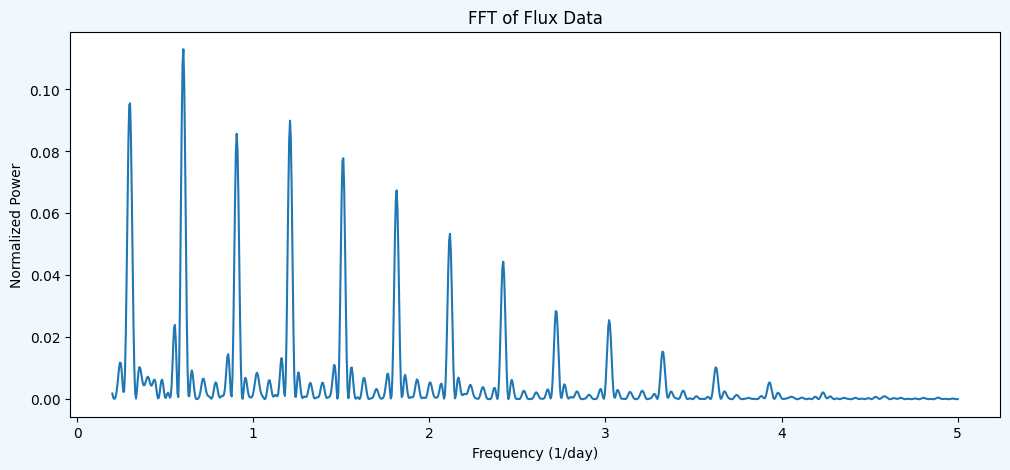

In [26]:
T = find_freq(dat, 5, 1000)[0]
print(f'Time period = {T} days')

<h3>Identifying and Fitting a Model to an Eclipse</h3>

t_0 = 1331.874337467175; t_total = 0.23518076954273218; t_in = 0.023773625877285362; depth = 417.7878705772469; f_star = 135899.59731821012
Figures/Time_Var_Plot_lc1_2


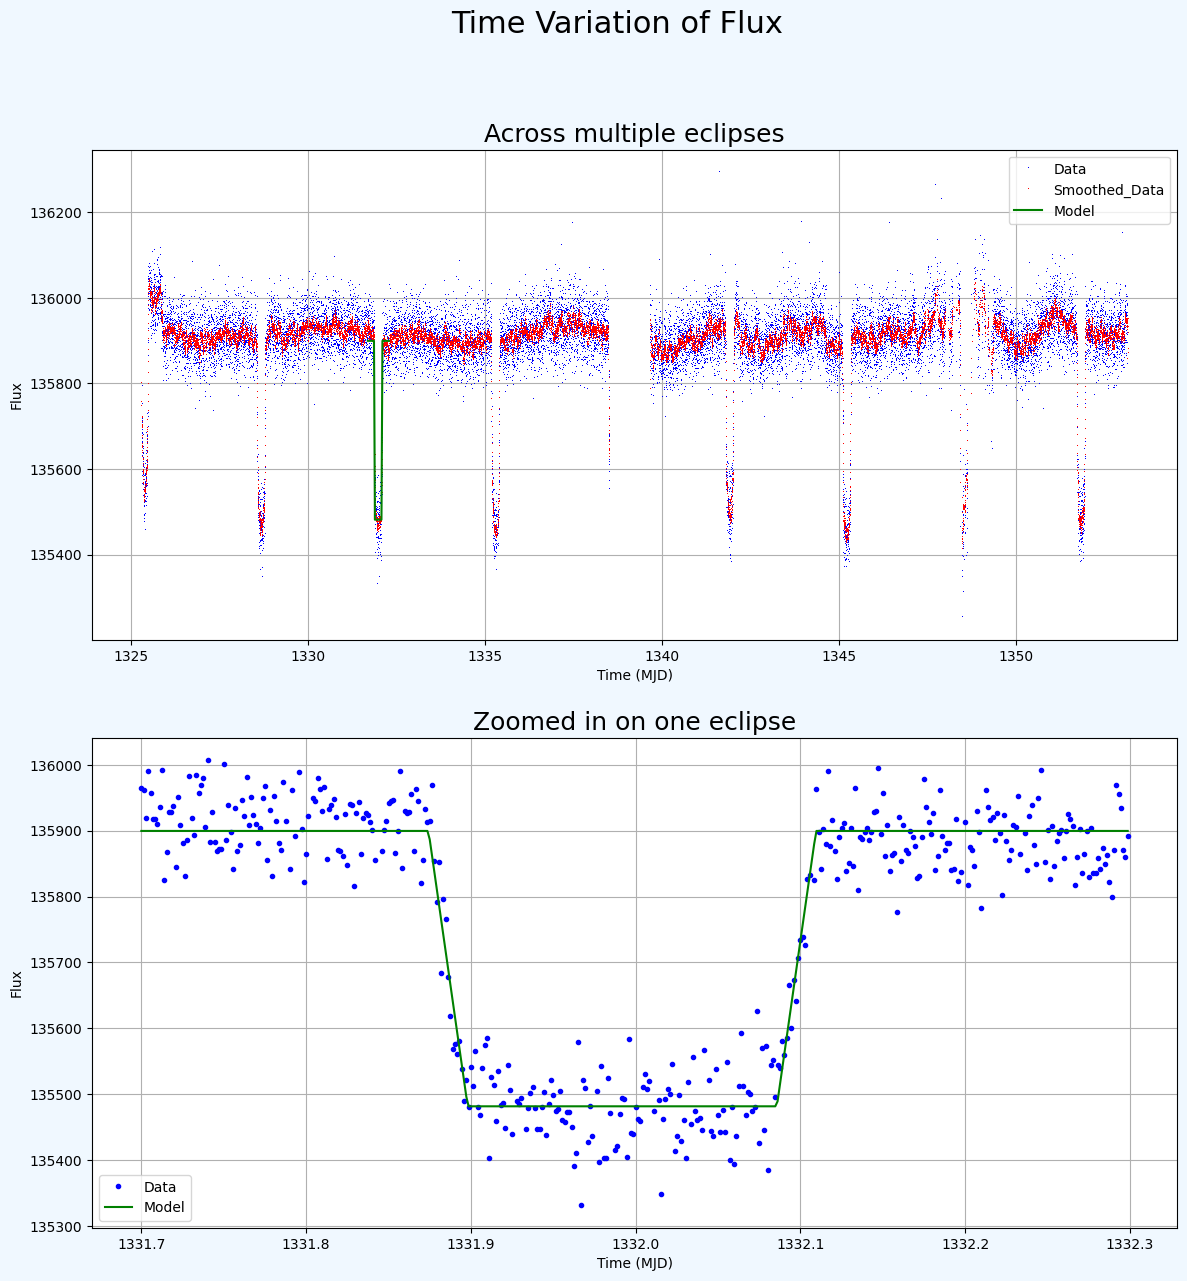

In [27]:
# Defining time window of the eclipse
window = 2 # set to 2 to read second eclipse data - convenient to save figure

if window == 1:
    time_start = 1328.4
    time_end = 1329
elif window == 2:
    time_start = 1331.7
    time_end = 1332.3

# Select relevant data of window
zoomed_in = dat[np.logical_and(dat[:,0] > time_start, dat[:,0] < time_end)]  # Can set the window range as variables eventually

# Plotting dataset across all time
fig_timeseries, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,14), facecolor='aliceblue')
ax1.plot(dat[:,0], dat[:,1], 'b,', label='Data')
ax1.plot(smoothed_dat[:,0], smoothed_dat[:,1], 'r,', label='Smoothed_Data')

#Plotting the zoomed in section
ax2.plot(zoomed_in[:,0], zoomed_in[:,1], 'b.', label='Data')

# Fitting the curve and plotting it
fit_params = fit_curve(zoomed_in, t_0=time_start, t_total=0.3, t_in=0.05, d=400, f_star=135900)
model = eclipse(zoomed_in[:,0], fit_params[0], fit_params[1], fit_params[2], fit_params[3], fit_params[4])

print(f't_0 = {fit_params[0]}; t_total = {fit_params[1]}; t_in = {fit_params[2]}; depth = {fit_params[3]}; f_star = {fit_params[4]}'); 

ax1.plot(zoomed_in[:,0], model, 'g', label='Model')
ax2.plot(zoomed_in[:,0], model, 'g', label='Model')

# More plot config stuff
fig_timeseries.suptitle('Time Variation of Flux', fontsize='22')
ax1.set_ylabel('Flux')
ax1.set_xlabel('Time (MJD)')
ax1.set_title('Across multiple eclipses', fontsize='18')
ax1.grid()
ax2.grid()

ax2.set_ylabel('Flux')
ax2.set_xlabel('Time (MJD)')
ax2.set_title('Zoomed in on one eclipse', fontsize='18')
print(f'Figures/Time_Var_Plot_{fname[-7:-4]}_{window}')
ax2.legend()
ax1.legend()
fig_timeseries.savefig(f'Figures/Time_Var_Plot_{fname[-7:-4]}_{window}')
plt.show()

Need to make the legend more visible <br>
Need to add units for flux
